# **Q Learning**

1 - Model free Environment


##  #1) The environment - Basic Gridworld

In [0]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections
import random
np.set_printoptions(suppress=True)

In [0]:
# Create the Environment
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        # 1 - Define the Environment
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # 2 - Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    # Transition function
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    # Calculate the distance between agent and goal
    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    # Reset the environment
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    # Step - Perform an action
    def step(self, action):
        # 1 - Get the agent position
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        # 2 -Get the distance between agent position and goal
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)

        # 3 - Calculate the reward based on the current and previous distance of agent from the goal
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        # 4 - Check terminating conditions (Either agent reaches the goal or number of timesteps equal to maximum timesteps for a given episode)
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        # 5 - Get the new state of the agent
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    # Output
    def render(self, mode='human'):
        plt.imshow(self.state)

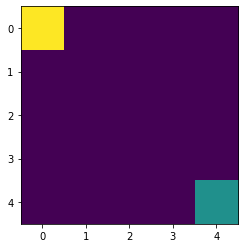

In [3]:
# Display the environment
env = GridEnvironment()
obs = env.reset()
env.render()


#### Environment Explanation:

We have selected a 5x5 grid environment as shown in the figure above.

1) **States:**

The initial state is at position (0,0) -> Represented by box in yellow color

The final state is at position (4,4) -> Represented by box in bluish green color

*State set:*

S = 

    {
      (0,0), (0,1), (0,2), (0,3), (0,4),
      (1,0), (1,1), (1,2), (1,3), (1,4),
      (2,0), (2,1), (2,2), (2,3), (2,4),
      (3,0), (3,1), (3,2), (3,3), (3,4),
      (4,0), (4,1), (4,2), (4,3), (4,4)
    }

2) **Actions:**

The agent can either go up, down, left or right

*Action set:*

A = {"up", "down", "left", "right"}


3) **Rewards:**

The reward for reaching closer to the final state is +1

The reward for reaching to a state which increases the distance between current position and the final state is -1

The reward for every other action is -1

*Reward set:*
R = {"+1", "-1"}

##  #2 Q-Learning Agent

## Tabular Q-Learning
This is where you need to define policy and update Q tables required to update policy.

*  
[np.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) - Returns the indices of the maximum values along an axis.

### 1 - Epsilon

It helps to decide whether our agent needs to take a random action (exploration) or an action based on the Q-value of the next state (exploitation).

Set epsilon to 1 initially (exploration = 100%) and use exponential-decay epsilon to reduce the value of epsilon (randomness of taking an action), gradually from one to zero.

Eventually update epsilon to 0 (exploitation = 100%).

### 2 - Process to select an action
Generate a random number between zero and one.

If random number is less than epsilon, select action based on the random choice

If random number is greater than epsilon, select action based on the Q-value of the state which will yield highest reward based on the current state


### 3 - Policy
It helps to select action based on the Q-value giving the highest reward from the current state to the next state

\begin{align} \notag
\pi\left(s_{t}\right)=\underset{a \in A}{\operatorname{argmax}} Q_{\theta}\left(s_{t}, a\right)
\end{align} 

###  4 - Update Q-table
\begin{align} \notag
            Q^{n e w}\left(s_{t}, a_{t}\right) \leftarrow(1-\alpha) \cdot \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }} + \underbrace{\gamma}_{\text {discount factor }} \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{a})}^{\text {learned value }}
            \end{align} 


### 5 - Algorithm
<!-- 
![Q-learning Algo](https://miro.medium.com/max/1512/1*Rf_H0YXhSPPm-iyBY2Gnjg.png) -->

![Q-learning Algo](https://miro.medium.com/max/640/1*B8tGarFYboV9maL93sF45Q.png)

In [0]:
class QLearningAgent:
    def __init__(self, env, epsilon=1, lr=0.77, gamma=0.9):
        # Initialize the agent variables
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    # Get the new action based on policy
    def policy(self, observation):
      # 1 - Exploration (action space)
      if random.uniform(0, 1) < self.epsilon:
          action = self.action_space.sample()
      # 2 - Exploitation (learned values)
      else:
          state = observation.astype(int)
          action = np.argmax(self.q_table[state[0], state[1]])
      return action
        
    # Step - Select a new action
    def step(self, observation):
      action = self.policy(observation)
      return action
        
    # Update Q-table
    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        old_q_value = self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] = (1 - self.lr)*old_q_value + self.lr*(reward+self.gamma*np.max(self.q_table[next_state[0], next_state[1], action]))
        
    # Update epsilon
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

### Training
### **A) Environment**
It consists of 4 main methods:

1) **Init:**

Initialize the environment

2) **Reset:**

Reset the environment at the beginning of each episode

3) **Step:**

Perform an action and return the new state, reward and an identifier which determines if the game is over

4) **Render:**

Output the current state of the environment


### **B) Steps for Training**

1) Initialize the environment and the agent

2) Initialize epsilon, delta_epsilon, rewards list, epsilons list and reward parameters (such as max_reward_per_episode, max_reward_per_episode_occurrence, total_episode_rewards to analyze the tuning of hyper-parameters)

3) Display the initial state of the environment

4) Run the Algorithm for a predefined set of episodes

5) Repeat steps 6 to 12 for each episode

6) Reset the environment and episodic parameters

7) Repeat steps 8 to 10 till the termination (done = True) of each episode

8) Store the current state of the environment (in obs_1) using the copy method

9) Perform the action using the step method of the agent and get the new state, action, reward and identifier (done) to check if the episode terminates

10) Use copy to save the new state returned by step. Update the state, action, reward, next_state of agent

11) Update the rewards list, epsilons list and reward parameters

12) Plot the graph for rewards vs episodes for every 100 episodes

13) Plot the final rewards vs episodes and epsilons vs episodes graphs


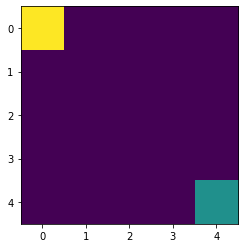

Episode 100

Rewards List Graph:


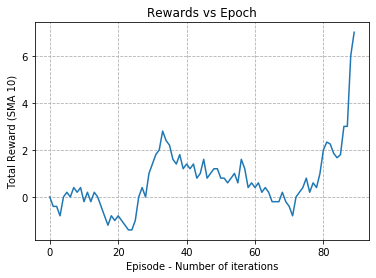

Episode 200

Rewards List Graph:


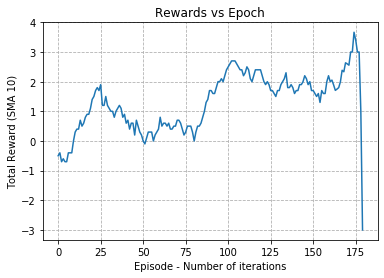

Episode 300

Rewards List Graph:


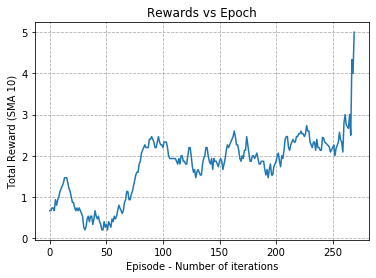

Episode 400

Rewards List Graph:


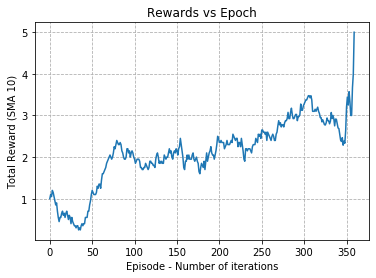

Episode 500

Rewards List Graph:


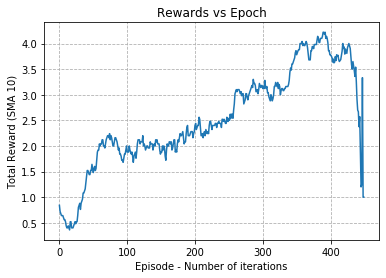

Episode 600

Rewards List Graph:


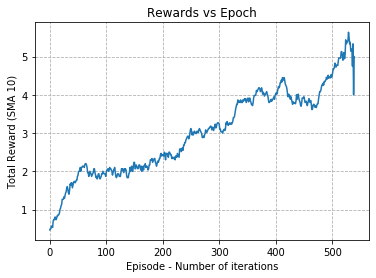

Episode 700

Rewards List Graph:


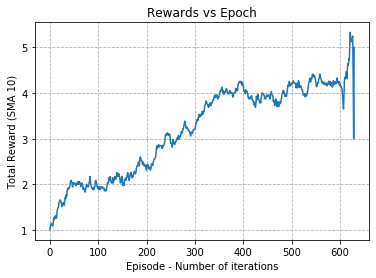

Episode 800

Rewards List Graph:


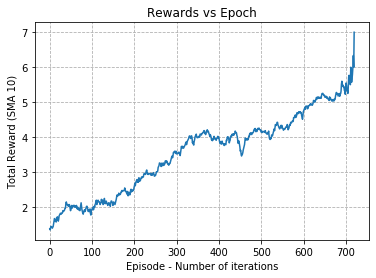


 Final Rewards List Graph:


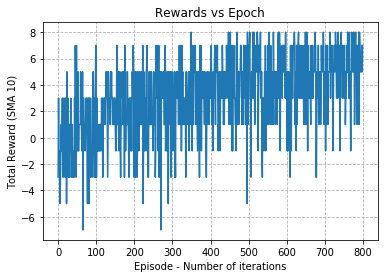


 Final Epsilons List Graph:


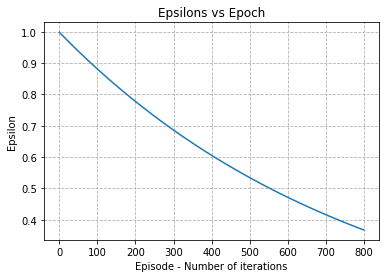

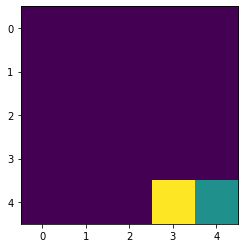

agent q table
[[[  2.47412742 -10.           1.64048133 -10.        ]
  [  1.66512948  -9.99851342   0.71164592  -9.99999999]
  [  1.05048109  -9.48422185  -0.32039342  -9.99999998]
  [  0.89581014  -5.85791782  -1.4671038   -9.99997209]
  [  3.03917614  -2.74216979  -3.30102272  -9.78031751]]

 [[  1.63791936 -10.           1.693182    -9.99999955]
  [  0.73871634  -9.99863001   0.77020222  -9.99999958]
  [ -0.05230526  -9.53579967  -0.25533087  -9.99999945]
  [ -1.0025123   -6.25149282  -1.40789471  -9.99999806]
  [  2.71        -3.46699076  -2.74216979  -9.83295762]]

 [[  0.70879929 -10.           0.94944901  -9.52393677]
  [ -0.29051339  -9.9987252   -0.06679709  -9.53579927]
  [ -1.1694981   -9.5822197   -1.18793376  -9.58221896]
  [ -2.49242627  -6.62557792  -2.43507372  -9.62399651]
  [  1.9         -4.11974959  -3.81684397  -9.65924466]]

 [[ -0.32356085  -9.99998471   0.38434152  -5.85791782]
  [ -1.43903877  -9.99594531  -0.93697652  -6.18173334]
  [ -2.41056564  -9.62397037

In [5]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 800 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes
total_rewards = []
epsilons = []

# Training Process (Task 3) (20 points)
obs = env.reset()
env.render()
plt.show()
window = 10
counter = 0
max_reward_per_episode = 0
max_reward_per_episode_occurrence = 0
total_episode_rewards = 0
while counter < episodes:
  counter += 1
  # print("\nEpisode = ",counter)
  done = False
  obs = env.reset()
  episode_reward = 0

  # Execution of an Episode
  while not done:
    action = agent.step(obs)
    obs_1 = obs.copy()
    obs, reward, done, info = env.step(action)
    agent.update(obs_1, action, reward, obs)
    episode_reward = episode_reward + reward
    obs_1 = obs.copy()
  agent.epsilon = agent.epsilon * (1 - delta_epsilon)
  agent.set_epsilon(agent.epsilon)
  epsilons.append(agent.epsilon)
  total_rewards.append(episode_reward)
  total_episode_rewards = total_episode_rewards + episode_reward
  if(max_reward_per_episode < episode_reward):
    max_reward_per_episode = episode_reward
    max_reward_per_episode_occurrence = 1
  elif(max_reward_per_episode == episode_reward):
    max_reward_per_episode_occurrence += 1

  # Graph after every 100 episodes
  if counter % 100 == 0:
    print ("Episode %d"%counter)
    print('\nRewards List Graph:')
    plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])
    plt.title("Rewards vs Epoch")
    plt.xlabel('Episode - Number of iterations')
    plt.ylabel('Total Reward (SMA 10)')
    plt.grid(ls='--')
    plt.show()
    window = window + 10

# Plot final graphs - 1 - Rewards vs Episode
print('\n Final Rewards List Graph:')
plt.plot(total_rewards)
plt.title("Rewards vs Epoch")
plt.xlabel('Episode - Number of iterations')
plt.ylabel('Total Reward (SMA 10)')
plt.grid(ls='--')
plt.show()

# Plot final graphs - 2 - Epsilon vs Episode
print('\n Final Epsilons List Graph:')
plt.plot(epsilons)
plt.title("Epsilons vs Epoch")
plt.xlabel('Episode - Number of iterations')
plt.ylabel('Epsilon')
plt.grid(ls='--')
plt.show()

env.render()
plt.show()
print('agent q table')
print(agent.q_table)

print('total_rewards')
print(format(total_rewards))

print('max_reward_per_episode')
print(max_reward_per_episode)

print('max_reward_per_episode_occurrence')
print(max_reward_per_episode_occurrence)

print('total_episode_rewards')
print(total_episode_rewards)

print('average_reward_per_episode')
print(total_episode_rewards/episodes)

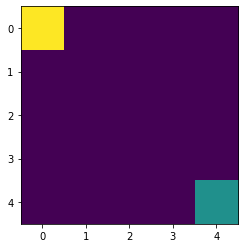

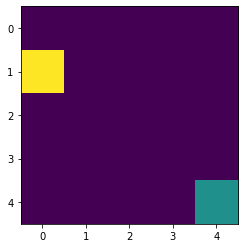

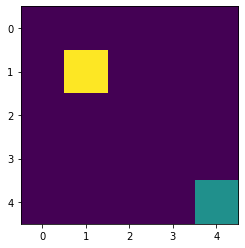

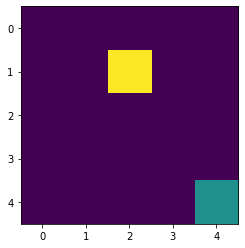

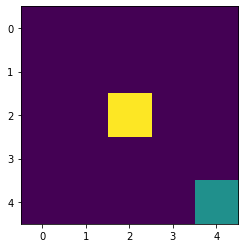

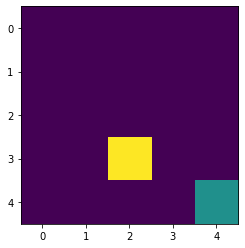

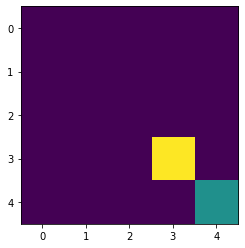

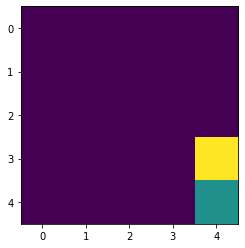

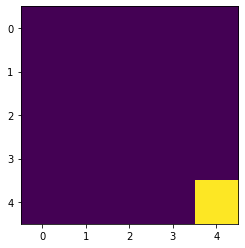

In [6]:
# Run the MDP process to check how the agent performs after training
env = GridEnvironment()
obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()